# Monthly Cross-Section: Analysis

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp
import pandas as pd

import warnings
import tqdm

import pandas_datareader.data as web
import datetime as dt

import statsmodels.api as sm
import linearmodels as lm

import matplotlib.pyplot as plt
import seaborn as sns

import mypack.data as data
import mypack.calc as calc
import mypack.plot as plot
import mypack.clas as clas

In [3]:
pd.set_option('display.float_format', lambda x: '%.4f' % x) #sets decimals to be displayed

In [4]:
sns.set()
sns.set(rc={'figure.figsize': (17, 6)})

In [5]:
%matplotlib inline

In [6]:
tqdm.tqdm.pandas()

## Data

In [7]:
df_xs_estimates = pd.read_pickle('df_xs_estimates_monthly.pkl')
df_xs_predictions = pd.read_pickle('df_xs_predictions_monthly.pkl')

In [8]:
hmm_name = 'HMM_full'

In [9]:
hmm_name = 'HMM_expand'

In [68]:
hmm_name = 'HMM_roll_40'

## Create Data to Analyse

In [10]:
df_xs_analysis = df_xs_estimates[hmm_name]
df_xs_analysis.columns = pd.MultiIndex.from_product([[0],df_xs_analysis.columns], names=['horizon','variable'])

df_xs_analysis = df_xs_analysis\
    .merge(df_xs_predictions[hmm_name], left_index=True, right_index=True)

In [14]:
df_xs_analysis.columns.get_level_values(1)

Index(['convergence', 'algorithm', 'T', 'aic', 'bic', 'likelihood', 'p00',
       'p10', 'mu_0', 'mu_1',
       ...
       'skew', 'kurt', 'std', 'entropy', 'cummean', 'cumvar', 'cumskew',
       'cumkurt', 'cumstd', 'cumentropy'],
      dtype='object', name='variable', length=213)

## Index Comparisons

In [11]:
df_index_comparison = pd.DataFrame(df_xs_analysis[[(1,'cumstd'),(3,'cumstd'),(12,'cumstd')]])\
    .groupby('Date').mean()*np.sqrt([12,4,1])*100

VIX = web.DataReader('VIXCLS', 'fred', start = '1926-01-01')
VIX.index = VIX.index+pd.tseries.offsets.MonthEnd(0)
VIX = VIX.groupby('DATE').tail(1)
VIX.columns = pd.MultiIndex.from_tuples([(1,'VIX')])

JLN = data.download_jln_financial_uncertainty()
JLN.index = JLN.index+pd.tseries.offsets.MonthEnd(0)
JLN.columns = pd.MultiIndex.from_product([[1,3,12],['JLN financial']], names=['a','horizon'])

df_index_comparison = df_index_comparison\
    .merge(df_xs_analysis[[(1,'cumentropy'),(3,'cumentropy'),(12,'cumentropy')]].groupby('Date').mean(), left_index=True, right_index=True)\
    .merge(VIX, left_index=True, right_index=True, how='left')\
    .merge(JLN, left_index=True, right_index=True, how='left')

ConnectionError: HTTPSConnectionPool(host='fred.stlouisfed.org', port=443): Max retries exceeded with url: /graph/fredgraph.csv?id=VIXCLS (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000001AB9B7C5E48>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

In [ ]:
index_correlations_table = pd.DataFrame(np.tril(df_index_comparison.corr(method='pearson')), index=df_index_comparison.columns.swaplevel(0,1), columns=df_index_comparison.columns.swaplevel(0,1))

index_correlations_table = index_correlations_table.replace(0,"")

#calc.export_df_to_latex(index_correlations_table, 'indexCorrelationsTable'+hmm_name)

index_correlations_table

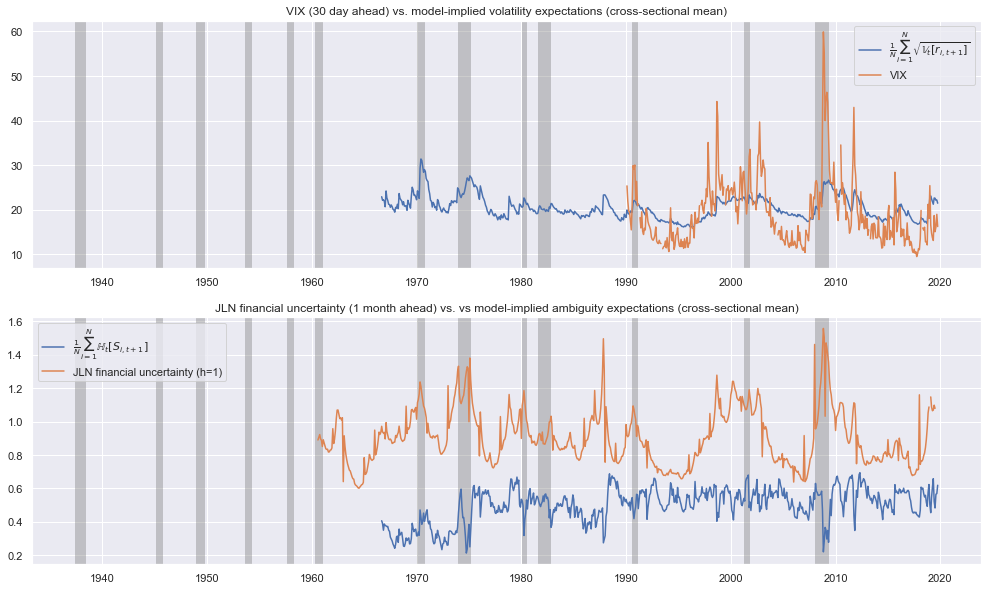

In [72]:
fig,axes = plt.subplots(2,1,figsize=[17,10])

ax = axes[0]
ax.plot(df_index_comparison[(1,'cumstd')], label='$\\frac{1}{N}\sum_{i=1}^{N}\sqrt{\mathbb{V}_t[r_{i,t+1}]}$')
ax.plot(df_index_comparison[(1,'VIX')], label='VIX')
plot.add_recession_bars(ax, startdate=df_index_comparison.index[120])
ax.legend()
ax.set_title('VIX (30 day ahead) vs. model-implied volatility expectations (cross-sectional mean)')

ax = axes[1]
ax.plot(df_index_comparison[(1,'cumentropy')], label='$\\frac{1}{N}\sum_{i=1}^{N}\mathbb{H}_t[S_{i,t+1}]$')
ax.plot(df_index_comparison[(1,'JLN financial')], label='JLN financial uncertainty (h=1)')
plot.add_recession_bars(ax, startdate=df_index_comparison.index[120])
ax.legend()
ax.set_title('JLN financial uncertainty (1 month ahead) vs. vs model-implied ambiguity expectations (cross-sectional mean)')

plt.show()

fig.savefig('indexComparisonPlots'+hmm_name+'.pdf', format='pdf', dpi=200, bbox_inches='tight')

In [73]:
# # BULLSHIT regression
# y=newframe['h=1'].diff(1).loc[newframe['h=1'].diff(1).notna()]
# x=sm.add_constant(newframe[(1, 'entropy')].diff(1).loc[newframe['h=1'].diff(1).notna()])
# sm.OLS(y,x).fit().summary()

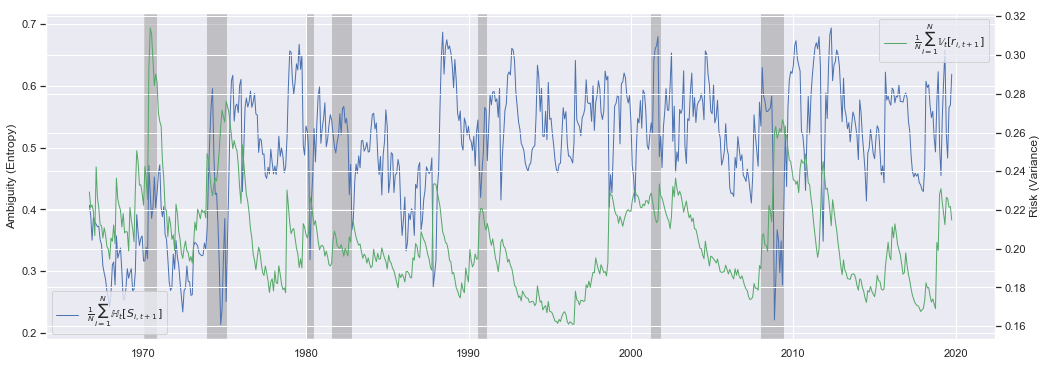

In [74]:
h=1

cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax1 = plt.subplots(figsize=[17,6])
ax2 = ax1.twinx()

ax1.plot(df_xs_predictions[hmm_name,h,'cumentropy'].groupby('Date').mean(), linewidth=1, color=cycle[0], alpha=1, label='$\\frac{1}{N}\sum_{i=1}^{N}\mathbb{H}_t[S_{i,t+1}]$', rasterized=True)
ax1.set_ylabel('Ambiguity (Entropy)')

ax2.plot(df_xs_predictions[hmm_name,h,'cumstd'].groupby('Date').mean()*np.sqrt(12/h), linewidth=1, color=cycle[2], alpha=1, label='$\\frac{1}{N}\sum_{i=1}^{N}\mathbb{V}_t[r_{i,t+1}]$', rasterized=True)
ax2.set_ylabel('Risk (Variance)')

ax1.legend(loc='lower left')
ax2.legend()

plot.add_recession_bars(ax1, startdate=df_xs_predictions.index[df_xs_predictions[hmm_name,h,'entropy'].notna()][0][0])

plt.show()

#fig.savefig('XSIndicesPlot'+hmm_name+'.pdf', format='pdf', dpi=200, bbox_inches='tight')

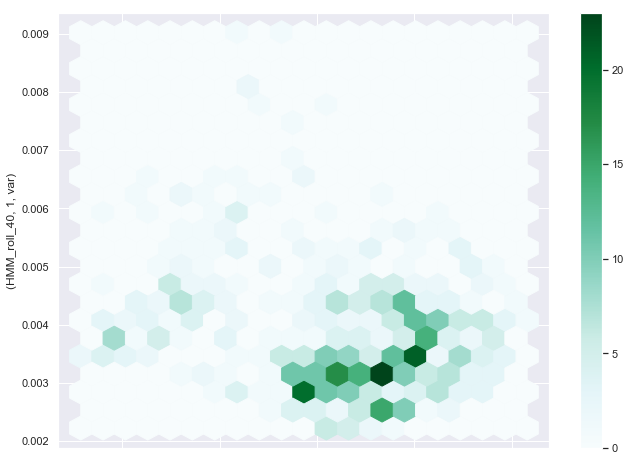

In [75]:
df_xs_predictions[[(hmm_name,h,'entropy'),(hmm_name,h,'var')]].groupby('Date').mean().plot.hexbin(x=(hmm_name,h,'entropy'), y=(hmm_name,h,'var'), gridsize=20, figsize=[11,8])
plt.show()

## Calculate

### Data Preparation

In [76]:
df_xs_reg = pd.DataFrame([], columns=pd.MultiIndex.from_product([[],[]]))

df_xs_reg[('mu_se',0)] = df_xs_analysis[(0,'filt_prob_0')]*df_xs_analysis[(0,'mu_0_se')]+df_xs_analysis[(0,'filt_prob_1')]*df_xs_analysis[(0,'mu_1_se')]
df_xs_reg[('sigma2_se',0)] = df_xs_analysis[(0,'filt_prob_0')]*df_xs_analysis[(0,'sigma2_0_se')]+df_xs_analysis[(0,'filt_prob_1')]*df_xs_analysis[(0,'sigma2_1_se')]
df_xs_reg[('rank_mu_se',0)] = df_xs_reg[('mu_se',0)].unstack().rank(axis=1, ascending=True).stack()
df_xs_reg[('rank_sigma2_se',0)] = df_xs_reg[('sigma2_se',0)].unstack().rank(axis=1, ascending=True).stack()

for h in tqdm.trange(1,13):
    df_xs_reg[('return',h)] = ((1+df_xs_estimates[('data','return')].unstack()).rolling(window=h).apply(np.prod, raw=True) - 1).stack()
    df_xs_reg[('E',h)] = df_xs_analysis[(0,'cummean')]
    df_xs_reg[('SD',h)] = df_xs_analysis[(0,'cumstd')]
    df_xs_reg[('V',h)] = df_xs_analysis[(0,'cumvar')]
    df_xs_reg[('S',h)] = df_xs_analysis[(0,'cumskew')]
    df_xs_reg[('K',h)] = df_xs_analysis[(0,'cumkurt')]
    df_xs_reg[('H',h)] = df_xs_analysis[(0,'cumentropy')]
    df_xs_reg[('rank_V',h)] = df_xs_reg[('V',h)].unstack().rank(axis=1, ascending=True).stack()
    df_xs_reg[('rank_H',h)] = df_xs_reg[('H',h)].unstack().rank(axis=1, ascending=True).stack()
    df_xs_reg[('rank_H_x_mu_se',h)] = df_xs_reg[('rank_H',h)]*df_xs_reg[('rank_mu_se',0)]
    df_xs_reg[('rank_H_x_sigma2_se',h)] = df_xs_reg[('rank_H',h)]*df_xs_reg[('rank_sigma2_se',0)]

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:12<00:00,  1.00s/it]


### Variable Summary Stats

In [77]:
x = df_xs_reg.iloc[:,0:11].loc[df_xs_reg[('mu_se',0)].notna()]

variable_names = ['$r_{i,t}$',
                  '$\mathbb{E}_t[r_{i,t+1}]$',
                  '$\mathbb{SD}_t[r_{i,t+1}]$',
                  '$\mathbb{V}_t[r_{i,t+1}]$',
                  '$\mathbb{S}_t[r_{i,t+1}]$',
                  '$\mathbb{K}_t[r_{i,t+1}]$',
                  '$\mathbb{H}_t[S_{i,t+1}]$',
                  '$\sum_{s_t=0}^{S} P[s_t] * s.e.(\mu_{i,t,s})$',
                  '$\sum_{s_t=0}^{S} P[s_t] * s.e.(\sigma^2_{i,t,s})$',
#                   '$Rank \sum_{s_t=0}^{S} P[s_t] * s.e.(\mu_{i,t,s})$',
#                   '$Rank \sum_{s_t=0}^{S} P[s_t] * s.e.(\sigma^2_{i,t,s})$',
                  ]

order = [4,5,6,7,8,9,10,0,1]

x = x.iloc[:,order]

regressors_table = pd.DataFrame(index=['N total','N (industry)','mean','std','min','median','max','skewness','kurtosis','Jarque-Bera (p)','autocorr (1)','Durbin-Watson','Aug. Dickey-Fuller (p)','']+variable_names, columns=variable_names)

regressors_table.loc['N total',:] = x.count().values
regressors_table.loc['N (industry)',:] = x.unstack().count().unstack().mean(axis=1).values
regressors_table.loc['mean',:] = x.unstack().mean().unstack().mean(axis=1).values
regressors_table.loc['std',:] = x.unstack().std().unstack().mean(axis=1).values
regressors_table.loc['min',:] = x.unstack().min().unstack().mean(axis=1).values
regressors_table.loc['median',:] = x.unstack().median().unstack().mean(axis=1).values
regressors_table.loc['max',:] = x.unstack().max().unstack().mean(axis=1).values
regressors_table.loc['skewness',:] = x.unstack().skew().unstack().mean(axis=1).values
regressors_table.loc['kurtosis',:] = x.unstack().kurt().unstack().mean(axis=1).values

#regressors_table.loc['autocorrelation (1-12)',:] = x.apply(lambda col: sum([col.autocorr(l) for l in range(1,2)]), axis=0).values

regressors_table.loc['Jarque-Bera (p)',:] = x.unstack().apply(lambda col: sm.stats.stattools.jarque_bera(col[col.notna()])[1], axis=0).unstack().mean(axis=1).values
regressors_table.loc['autocorr (1)',:] = x.unstack().apply(lambda col: col.autocorr(1), axis=0).unstack().mean(axis=1).values
regressors_table.loc['Durbin-Watson',:] = x.unstack().apply(lambda col: sm.stats.stattools.durbin_watson(col[col.notna()])).unstack().mean(axis=1).values
regressors_table.loc['Aug. Dickey-Fuller (p)',:] = x.unstack().progress_apply(lambda col: sm.tsa.stattools.adfuller(col[col.notna()], autolag='AIC')[1]).unstack().mean(axis=1).values

regressors_table.loc[variable_names,:] = np.tril(x.iloc[:,:].corr().values)
regressors_table.loc[variable_names,:] = regressors_table.loc[variable_names,:].replace(0,'')

regressors_table = regressors_table.replace(np.nan,'')

calc.export_df_to_latex(regressors_table, 'dataSummaryTable'+hmm_name)

regressors_table

100%|████████████████████████████████████████████████████████████████████████████████| 441/441 [00:13<00:00, 33.52it/s]


$r_{i,t}$  \
N total                                                28406   
N (industry)                                        579.7143   
mean                                                  0.0065   
std                                                   0.0636   
min                                                  -0.2791   
median                                                0.0076   
max                                                   0.2738   
skewness                                             -0.1511   
kurtosis                                              2.3220   
Jarque-Bera (p)                                       0.0104   
autocorr (1)                                          0.0647   
Durbin-Watson                                         1.8422   
Aug. Dickey-Fuller (p)                                0.0000   
                                                               
$r_{i,t}$                                             1.0000   
$\mathbb{E}_t[r_{i,t+1}]$                             0.1895   
$\mathbb{SD}_t[r_{i,t+1}]$                           -0.0314   
$\mathbb{V}_t[r_{i,t+1}]$                            -0.0236   
$\mathbb{S}_t[r_{i,t+1}]$                            -0.0368   
$\mathbb{K}_t[r_{i,t+1}]$                             0.0131   
$\mathbb{H}_t[S_{i,t+1}]$                            -0.0303   
$\sum_{s_t=0}^{S} P[s_t] * s.e.(\mu_{i,t,s})$        -0.0020   
$\sum_{s_t=0}^{S} P[s_t] * s.e.(\sigma^2_{i,t,s})$   -0.0037   

                                                   $\mathbb{E}_t[r_{i,t+1}]$  \
N total                                                                28406   
N (industry)                                                        579.7143   
mean                                                                  0.0070   
std                                                                   0.0044   
min                                                                  -0.0140   
median                                                                0.0078   
max                                                                   0.0149   
skewness                                                             -1.0109   
kurtosis                                                              3.9880   
Jarque-Bera (p)                                                       0.0039   
autocorr (1)                                                          0.8796   
Durbin-Watson                                                         0.1042   
Aug. Dickey-Fuller (p)                                                0.0352   
                                                                               
$r_{i,t}$                                                                      
$\mathbb{E}_t[r_{i,t+1}]$                                             1.0000   
$\mathbb{SD}_t[r_{i,t+1}]$                                           -0.2206   
$\mathbb{V}_t[r_{i,t+1}]$                                            -0.1891   
$\mathbb{S}_t[r_{i,t+1}]$                                            -0.2190   
$\mathbb{K}_t[r_{i,t+1}]$                                             0.2024   
$\mathbb{H}_t[S_{i,t+1}]$                                            -0.1586   
$\sum_{s_t=0}^{S} P[s_t] * s.e.(\mu_{i,t,s})$                        -0.0241   
$\sum_{s_t=0}^{S} P[s_t] * s.e.(\sigma^2_{i,t,s})$                   -0.0201   

                                                   $\mathbb{SD}_t[r_{i,t+1}]$  \
N total                                                                 28406   
N (industry)                                                         579.7143   
mean                                                                   0.0595   
std                                                                    0.0128   
min                                                                    0.0389   
median                                                                 0.0576   
max                       

### Pooled Regressions

In [78]:
df_xs_reg.columns.tolist()[0:20]+['...']

[('mu_se', 0),
 ('sigma2_se', 0),
 ('rank_mu_se', 0),
 ('rank_sigma2_se', 0),
 ('return', 1),
 ('E', 1),
 ('SD', 1),
 ('V', 1),
 ('S', 1),
 ('K', 1),
 ('H', 1),
 ('rank_V', 1),
 ('rank_H', 1),
 ('rank_H_x_mu_se', 1),
 ('rank_H_x_sigma2_se', 1),
 ('return', 2),
 ('E', 2),
 ('SD', 2),
 ('V', 2),
 ('S', 2),
 '...']

In [79]:
index_dict = {'constant': 'constant',
              'E': '$\mathbb{E}_t[r_{i,t+1}]$',
              'SD': '$\mathbb{SD}_t[r_{i,t+1}]$',
              'V': '$\mathbb{V}_t[r_{i,t+1}]$',
              'S': '$\mathbb{S}_t[r_{i,t+1}]$',
              'K': '$\mathbb{K}_t[r_{i,t+1}]$',
              'H': '$\mathbb{H}_t[S_{i,t+1}]$',
              'rank_H': '$rank(\mathbb{H}_t[S_{i,t+1}])$',
              'mu_se': '$\sum_{s_t=0}^{S} P[s_t] * s.e.(\mu_{i,t,s})$',
              'sigma2_se': '$\sum_{s_t=0}^{S} P[s_t] * s.e.(\sigma^2_{i,t,s})$',
              'rank_H_x_mu_se': '$rank(\mathbb{H}_t[S_{i,t+1}]) \times rank(\sum_{s_t=0}^{S} P[s_t] * s.e.(\mu_{i,t,s}))$',
              'rank_H_x_sigma2_se': '$rank(\mathbb{H}_t[S_{i,t+1}]) \times rank(\sum_{s_t=0}^{S} P[s_t] * s.e.(\sigma^2_{i,t,s}))$',
              'N': 'N',
              'Regression P-value': 'Regression P-value',
              'R$^2$ (model)': 'R$^2$ (model)',
             }

In [80]:
h = 1

dependent = [('return',1)]
independents = [[('H',1)],
                [('rank_H',1)],
                [('V',1)],
                [('V',1),('H',1)],
                [('rank_H',1),('V',1)],
                [('E',1),('V',1),('S',1),('K',1),('H',1)],
                [('E',1),('V',1),('S',1),('K',1),('rank_H',1)],
                [('mu_se', 0),('sigma2_se', 0),('H',1)],
                [('mu_se', 0),('sigma2_se', 0),('rank_H',1)],
                [('rank_H_x_mu_se', 1),('H',1)],
                [('rank_H_x_sigma2_se', 1),('H',1)],
               ]

row_labels = [str(i[0]) for i in calc.get_unique_values_from_list_of_lists(independents)]
y = df_xs_reg.loc[:,dependent].groupby('Industry').shift(-h)

reg_table = pd.DataFrame(index=pd.MultiIndex.from_product([['constant']+row_labels,['coefficient estimate','t-statistic','t-statistic (DK)']]), columns=range(1,len(independents)+1))

col = 0
for select in independents:
    x = df_xs_reg.loc[:,select]
    #reg = sm.OLS(y, sm.add_constant(x.iloc[:,select]), missing='drop').fit()
    reg = lm.PanelOLS(y.swaplevel(0,1), sm.add_constant(x.swaplevel(0,1)), entity_effects=False, time_effects=False)
    regf = reg.fit()
    
    reg_table.iloc[[0]+[row_labels.index(str(v[0]))*3+3 for v in select],col] = regf.params.values
    reg_table.iloc[[1]+[row_labels.index(str(v[0]))*3+4 for v in select],col] = regf.tstats.values
    reg_table.iloc[[2]+[row_labels.index(str(v[0]))*3+5 for v in select],col] = reg.fit(cov_type='kernel').tstats.values
    reg_table.loc['N',col+1] = int(regf.nobs)
    reg_table.loc['Regression P-value',col+1] = regf.f_statistic.pval
    reg_table.loc['R$^2$ (model)',col+1] = regf.rsquared
    
    col += 1

reg_table.index = pd.MultiIndex.from_arrays([[index_dict.get(i) for i in list(reg_table.index.get_level_values(0))],list(reg_table.index.get_level_values(1))])
    
calc.export_df_to_latex(reg_table, 'pooledRegTable'+hmm_name)    

reg_table.replace(np.nan,'')

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\utility.py:454: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:326: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  return np.asarray(self._frame.index.labels[0])[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:338: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  return np.asarray(self._frame.index.labels[1])[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:314: FutureWarning: .labels was deprecated in version 0.2

1   \
constant                                           coefficient estimate  0.0069   
                                                   t-statistic          10.0628   
                                                   t-statistic (DK)      2.6845   
$\mathbb{H}_t[S_{i,t+1}]$                          coefficient estimate -0.0014   
                                                   t-statistic          -1.1420   
                                                   t-statistic (DK)     -0.5544   
$rank(\mathbb{H}_t[S_{i,t+1}])$                    coefficient estimate           
                                                   t-statistic                    
                                                   t-statistic (DK)               
$\mathbb{V}_t[r_{i,t+1}]$                          coefficient estimate           
                                                   t-statistic                    
                                                   t-statistic (DK)               
$\mathbb{E}_t[r_{i,t+1}]$                          coefficient estimate           
                                                   t-statistic                    
                                                   t-statistic (DK)               
$\mathbb{S}_t[r_{i,t+1}]$                          coefficient estimate           
                                                   t-statistic                    
                                                   t-statistic (DK)               
$\mathbb{K}_t[r_{i,t+1}]$                          coefficient estimate           
                                                   t-statistic                    
                                                   t-statistic (DK)               
$\sum_{s_t=0}^{S} P[s_t] * s.e.(\mu_{i,t,s})$      coefficient estimate           
                                                   t-statistic                    
                                                   t-statistic (DK)               
$\sum_{s_t=0}^{S} P[s_t] * s.e.(\sigma^2_{i,t,s})$ coefficient estimate           
                                                   t-statistic                    
                                                   t-statistic (DK)               
$rank(\mathbb{H}_t[S_{i,t+1}]) \times rank(\sum... coefficient estimate           
                                                   t-statistic                    
                                                   t-statistic (DK)               
$rank(\mathbb{H}_t[S_{i,t+1}]) \times rank(\sum... coefficient estimate           
                                                   t-statistic                    
                                                   t-statistic (DK)               
N                                                                         28357   
Regression P-value                                                       0.2535   
R$^2$ (model)                                                            0.0000   

                                                                            2   \
constant                                           coefficient estimate 0.0062   
                                                   t-statistic          8.0669   
                                                   t-statistic (DK)     2.9143   
$\mathbb{H}_t[S_{i,t+1}]$                          coefficient estimate          
                                                   t-statistic                   
                                                   t-statistic (DK)              
$rank(\mathbb{H}_t[S_{i,t+1}])$                    coefficient estimate 0.0000   
                                                   t-statistic          0.0673   
                                                   t-statistic (DK)     0.0665   
$\mathbb{V}_t[r_{i,t+1}]$                          coefficient estimate          
                                                   t-statistic                   
                     

#### Longer Horizons

In [81]:
row_labels = ['V']

reg_table = pd.DataFrame(index=pd.MultiIndex.from_product([['constant']+row_labels,['coefficient estimate','t-statistic','t-statistic (DK)']]), columns=range(1,13))

col = 0
for h in range(1,13):
    
    dependent = [('return',h)]
    y = df_xs_reg.loc[:,dependent].groupby('Industry').shift(-h)
    
    select = [(row_labels[0],h)]
    x = df_xs_reg.loc[:,select]
    
    #reg = sm.OLS(y, sm.add_constant(x.iloc[:,select]), missing='drop').fit()
    reg = lm.PanelOLS(y.swaplevel(0,1), sm.add_constant(x.swaplevel(0,1)), entity_effects=False, time_effects=False)
    regf = reg.fit()
    
    reg_table.iloc[[0]+[3],col] = regf.params.values
    reg_table.iloc[[1]+[4],col] = regf.tstats.values
    reg_table.iloc[[2]+[5],col] = reg.fit(cov_type='kernel').tstats.values
    reg_table.loc['N',col+1] = int(regf.nobs)
    reg_table.loc['Regression P-value',col+1] = regf.f_statistic.pval
    reg_table.loc['R$^2$ (model)',col+1] = regf.rsquared
    
    col += 1 

variance_horizon_table = reg_table.copy()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\utility.py:454: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:326: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  return np.asarray(self._frame.index.labels[0])[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:338: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  return np.asarray(self._frame.index.labels[1])[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:314: FutureWarning: .labels was deprecated in version 0.2

In [82]:
variance_horizon_table#.replace(np.nan,'')

1      2      3       4       5   \
constant           coefficient estimate 0.0045 0.0082 0.0120  0.0158  0.0199   
                   t-statistic          6.4837 8.0321 9.4630 10.6915 11.9317   
                   t-statistic (DK)     2.2337 2.0998 2.1163  2.1594  2.2253   
V                  coefficient estimate 0.4719 1.2707 2.0527  2.8241  3.4932   
                   t-statistic          3.0336 5.5830 7.2745  8.5674  9.3684   
                   t-statistic (DK)     0.8086 1.1674 1.3075  1.3957  1.4231   
N                                        28357  28308  28259   28210   28161   
Regression P-value                      0.0024 0.0000 0.0000  0.0000  0.0000   
R$^2$ (model)                           0.0003 0.0011 0.0019  0.0026  0.0031   

                                             6       7       8       9   \
constant           coefficient estimate  0.0247  0.0299  0.0354  0.0419   
                   t-statistic          13.3135 14.9090 16.4926 18.3026   
                   t-statistic (DK)      2.3451  2.5002  2.6727  2.8906   
V                  coefficient estimate  4.0315  4.3624  4.6064  4.5806   
                   t-statistic           9.7541  9.7377  9.6036  8.9689   
                   t-statistic (DK)      1.4202  1.3709  1.3254  1.2219   
N                                         28112   28063   28014   27965   
Regression P-value                       0.0000  0.0000  0.0000  0.0000   
R$^2$ (model)                            0.0034  0.0034  0.0033  0.0029   

                                             10      11      12  
constant           coefficient estimate  0.0477  0.0532  0.0597  
                   t-statistic          19.7601 21.0486 22.5772  
                   t-statistic (DK)      3.0641  3.2240  3.4361  
V                  coefficient estimate  4.6704  4.8803  4.8390  
                   t-statistic           8.6666  8.6433  8.1894  
                   t-statistic (DK)      1.1844  1.2084  1.1747  
N                                         27916   27867   27818  
Regression P-value                       0.0000  0.0000  0.0000  
R$^2$ (model)                            0.0027  0.0027  0.0024

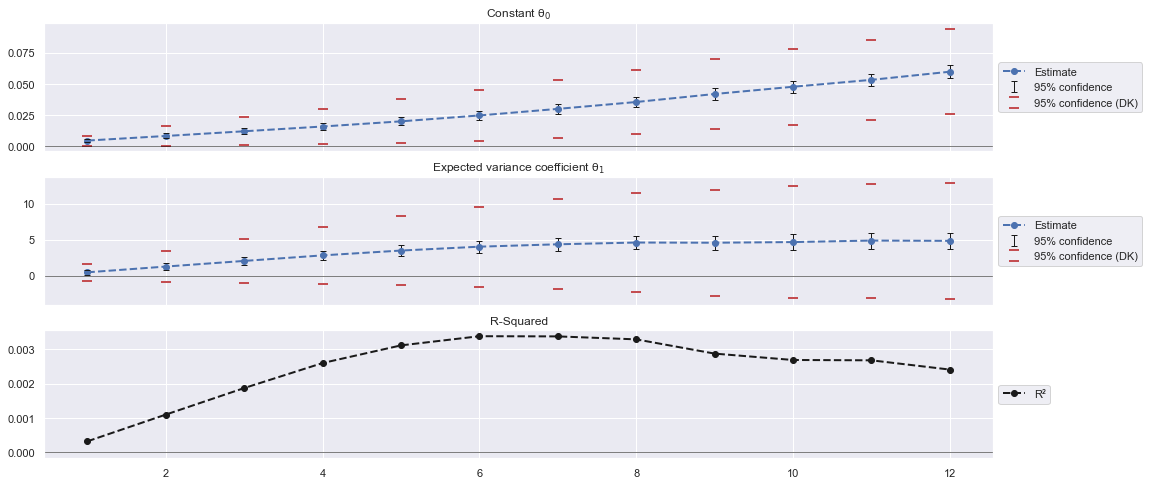

In [83]:
fig, axes = plt.subplots(3, 1, figsize=(17,8))

axes[0].plot(variance_horizon_table.T['constant','coefficient estimate'], linewidth=2, label='Estimate', linestyle='--', marker='o')
axes[0].errorbar(range(1,13),variance_horizon_table.T['constant','coefficient estimate'],\
                 yerr=variance_horizon_table.T['constant','coefficient estimate']/variance_horizon_table.T['constant','t-statistic']*1.96,
                 fmt='none', color='k', linewidth=1, capsize=3, label='95% confidence')
axes[0].errorbar(range(1,13),variance_horizon_table.T['constant','coefficient estimate'],\
                 yerr=variance_horizon_table.T['constant','coefficient estimate']/variance_horizon_table.T['constant','t-statistic (DK)']*1.96,
                 fmt='none', color='r', linewidth=0, capsize=5, markeredgewidth=2, label='95% confidence (DK)')
axes[0].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[0].set_title('Constant θ$_0$')
axes[0].legend(loc='center left', bbox_to_anchor=(1,0.5))
axes[0].set_xticklabels([])

axes[1].plot(variance_horizon_table.T['V','coefficient estimate'], linewidth=2, label='Estimate', linestyle='--', marker='o')
axes[1].errorbar(range(1,13),variance_horizon_table.T['V','coefficient estimate'],\
                 yerr=variance_horizon_table.T['V','coefficient estimate']/variance_horizon_table.T['V','t-statistic']*1.96,
                 fmt='none', color='k', linewidth=1, capsize=3, label='95% confidence')
axes[1].errorbar(range(1,13),variance_horizon_table.T['V','coefficient estimate'],\
                 yerr=variance_horizon_table.T['V','coefficient estimate']/variance_horizon_table.T['V','t-statistic (DK)']*1.96,
                 fmt='none', color='r', linewidth=0, capsize=5, markeredgewidth=2, label='95% confidence (DK)')
axes[1].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[1].set_title('Expected variance coefficient θ$_1$')
axes[1].legend(loc='center left', bbox_to_anchor=(1,0.5))
axes[1].set_xticklabels([])

axes[2].plot(variance_horizon_table.T['R$^2$ (model)',''], linewidth=2, linestyle='--', marker='o', color='k', label='R²')
axes[2].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[2].set_title('R-Squared')
axes[2].legend(loc='center left', bbox_to_anchor=(1,0.5))

plt.subplots_adjust(hspace=0.2)

fig.savefig('varianceHorizonsPlot'+hmm_name+'.pdf', format='pdf', dpi=200, bbox_inches='tight')

plt.show()

In [84]:
row_labels = ['H']

reg_table = pd.DataFrame(index=pd.MultiIndex.from_product([['constant']+row_labels,['coefficient estimate','t-statistic','t-statistic (DK)']]), columns=range(1,13))

col = 0
for h in range(1,13):
    
    dependent = [('return',h)]
    y = df_xs_reg.loc[:,dependent].groupby('Industry').shift(-h)
    
    select = [(row_labels[0],h)]
    x = df_xs_reg.loc[:,select]
    
    #reg = sm.OLS(y, sm.add_constant(x.iloc[:,select]), missing='drop').fit()
    reg = lm.PanelOLS(y.swaplevel(0,1), sm.add_constant(x.swaplevel(0,1)), entity_effects=False, time_effects=False)
    regf = reg.fit()
    
    reg_table.iloc[[0]+[3],col] = regf.params.values
    reg_table.iloc[[1]+[4],col] = regf.tstats.values
    reg_table.iloc[[2]+[5],col] = reg.fit(cov_type='kernel').tstats.values
    reg_table.loc['N',col+1] = int(regf.nobs)
    reg_table.loc['Regression P-value',col+1] = regf.f_statistic.pval
    reg_table.loc['R$^2$ (model)',col+1] = regf.rsquared
    
    col += 1
    
#calc.export_df_to_latex(reg_table, 'horizonRegTable')    

entropy_horizon_table = reg_table.copy()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\utility.py:454: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:326: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  return np.asarray(self._frame.index.labels[0])[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:338: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  return np.asarray(self._frame.index.labels[1])[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:314: FutureWarning: .labels was deprecated in version 0.2

In [85]:
entropy_horizon_table#.replace(np.nan,'')

1       2       3       4   \
constant           coefficient estimate  0.0069  0.0147  0.0218  0.0292   
                   t-statistic          10.0628 14.5807 17.3879 19.9389   
                   t-statistic (DK)      2.6845  3.0295  3.0196  3.0859   
H                  coefficient estimate -0.0014 -0.0038 -0.0045 -0.0060   
                   t-statistic          -1.1420 -2.1111 -2.0406 -2.3216   
                   t-statistic (DK)     -0.5544 -0.8323 -0.6862 -0.6914   
N                                         28357   28308   28259   28210   
Regression P-value                       0.2535  0.0348  0.0413  0.0203   
R$^2$ (model)                            0.0000  0.0002  0.0001  0.0002   

                                             5       6       7       8   \
constant           coefficient estimate  0.0370  0.0442  0.0502  0.0561   
                   t-statistic          22.3233 24.0793 25.1940 26.3025   
                   t-statistic (DK)      3.2205  3.3441  3.3824  3.4551   
H                  coefficient estimate -0.0084 -0.0095 -0.0083 -0.0073   
                   t-statistic          -2.8874 -2.9395 -2.3674 -1.9245   
                   t-statistic (DK)     -0.7959 -0.7721 -0.5965 -0.4725   
N                                         28161   28112   28063   28014   
Regression P-value                       0.0039  0.0033  0.0179  0.0543   
R$^2$ (model)                            0.0003  0.0003  0.0002  0.0001   

                                             9       10      11      12  
constant           coefficient estimate  0.0606  0.0651  0.0695  0.0731  
                   t-statistic          26.6990 27.1643 27.6920 27.8162  
                   t-statistic (DK)      3.4695  3.4974  3.5393  3.5105  
H                  coefficient estimate -0.0035  0.0001  0.0041  0.0101  
                   t-statistic          -0.8663  0.0175  0.9275  2.1800  
                   t-statistic (DK)     -0.2096  0.0042  0.2172  0.4961  
N                                         27965   27916   27867   27818  
Regression P-value                       0.3863  0.9860  0.3537  0.0293  
R$^2$ (model)                            0.0000  0.0000  0.0000  0.0002

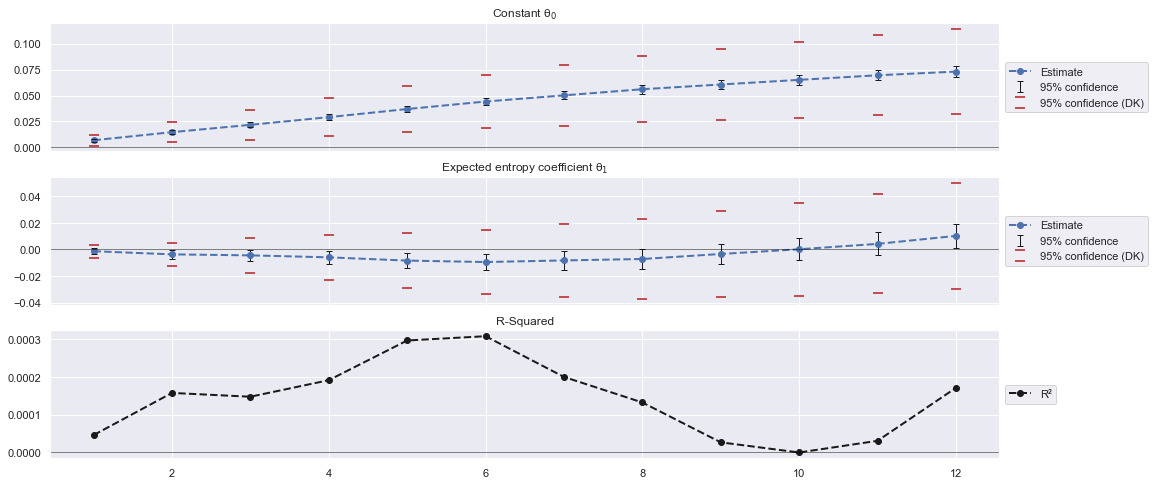

In [86]:
fig, axes = plt.subplots(3, 1, figsize=(17,8))

axes[0].plot(entropy_horizon_table.T['constant','coefficient estimate'], linewidth=2, label='Estimate', linestyle='--', marker='o')
axes[0].errorbar(range(1,13),entropy_horizon_table.T['constant','coefficient estimate'],\
                 yerr=entropy_horizon_table.T['constant','coefficient estimate']/entropy_horizon_table.T['constant','t-statistic']*1.96,
                 fmt='none', color='k', linewidth=1, capsize=3, label='95% confidence')
axes[0].errorbar(range(1,13),entropy_horizon_table.T['constant','coefficient estimate'],\
                 yerr=entropy_horizon_table.T['constant','coefficient estimate']/entropy_horizon_table.T['constant','t-statistic (DK)']*1.96,
                 fmt='none', color='r', linewidth=0, capsize=5, markeredgewidth=2, label='95% confidence (DK)')
axes[0].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[0].set_title('Constant θ$_0$')
axes[0].legend(loc='center left', bbox_to_anchor=(1,0.5))
axes[0].set_xticklabels([])

axes[1].plot(entropy_horizon_table.T['H','coefficient estimate'], linewidth=2, label='Estimate', linestyle='--', marker='o')
axes[1].errorbar(range(1,13),entropy_horizon_table.T['H','coefficient estimate'],\
                 yerr=entropy_horizon_table.T['H','coefficient estimate']/entropy_horizon_table.T['H','t-statistic']*1.96,
                 fmt='none', color='k', linewidth=1, capsize=3, label='95% confidence')
axes[1].errorbar(range(1,13),entropy_horizon_table.T['H','coefficient estimate'],\
                 yerr=entropy_horizon_table.T['H','coefficient estimate']/entropy_horizon_table.T['H','t-statistic (DK)']*1.96,
                 fmt='none', color='r', linewidth=0, capsize=5, markeredgewidth=2, label='95% confidence (DK)')
axes[1].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[1].set_title('Expected entropy coefficient θ$_1$')
axes[1].legend(loc='center left', bbox_to_anchor=(1,0.5))
axes[1].set_xticklabels([])

axes[2].plot(entropy_horizon_table.T['R$^2$ (model)',''], linewidth=2, linestyle='--', marker='o', color='k', label='R²')
axes[2].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[2].set_title('R-Squared')
axes[2].legend(loc='center left', bbox_to_anchor=(1,0.5))

plt.subplots_adjust(hspace=0.2)

fig.savefig('entropyHorizonsPlot'+hmm_name+'.pdf', format='pdf', dpi=200, bbox_inches='tight')

plt.show()

### Panel Regressions

In [87]:
index_dict.update({'time FE': 'time FE',
                   'industry FE': 'industry FE',
                   'R$^2$ (inclusive)': 'R$^2$ (inclusive)',
                  })


In [88]:
h = 1

dependent = [('return',1)]
independents = [[('H',1)],
#                 [('rank_H',1)],
#                 [('V',1)],
                [('V',1),('H',1)],
#                 [('rank_H',1),('V',1)],
#                 [('E',1),('V',1),('S',1),('K',1),('H',1)],
#                 [('E',1),('V',1),('S',1),('K',1),('rank_H',1)],
#                 [('mu_se', 0),('sigma2_se', 0),('H',1)],
#                 [('mu_se', 0),('sigma2_se', 0),('rank_H',1)],
#                 [('rank_H_x_mu_se', 1),('H',1)],
#                 [('rank_H_x_sigma2_se', 1),('H',1)],
               ]

row_labels = [str(i[0]) for i in calc.get_unique_values_from_list_of_lists(independents)]
y = df_xs_reg.loc[:,dependent].groupby('Industry').shift(-h)

reg_table = pd.DataFrame(index=pd.MultiIndex.from_product([['constant']+row_labels,['coefficient estimate','t-statistic','t-statistic (DK)']]), columns=range(1,len(independents)*4+1))

col = 0
for select in independents:
    x = df_xs_reg.loc[:,select]
    
    for (ent,tim) in [(False,False),(True,False),(False,True),(True,True)]:
        reg = lm.PanelOLS(y.swaplevel(0,1), sm.add_constant(x.swaplevel(0,1)), entity_effects=ent, time_effects=tim)
        regf = reg.fit()
    
        reg_table.iloc[[0]+[row_labels.index(str(v[0]))*3+3 for v in select],col] = regf.params.values
        reg_table.iloc[[1]+[row_labels.index(str(v[0]))*3+4 for v in select],col] = regf.tstats.values
        reg_table.iloc[[2]+[row_labels.index(str(v[0]))*3+5 for v in select],col] = reg.fit(cov_type='kernel').tstats.values
        reg_table.loc['time FE',col+1] = tim
        reg_table.loc['industry FE',col+1] = ent
        reg_table.loc['N',col+1] = int(regf.nobs)
        reg_table.loc['Regression P-value',col+1] = regf.f_statistic.pval
        reg_table.loc['R$^2$ (model)',col+1] = regf.rsquared
        reg_table.loc['R$^2$ (inclusive)',col+1] = regf.rsquared_inclusive
    
        col += 1

reg_table.index = pd.MultiIndex.from_arrays([[index_dict.get(i) for i in list(reg_table.index.get_level_values(0))],list(reg_table.index.get_level_values(1))])        
        
calc.export_df_to_latex(reg_table, 'panelRegTable'+hmm_name)

reg_table.replace(np.nan,'')

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\utility.py:454: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:326: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  return np.asarray(self._frame.index.labels[0])[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:338: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  return np.asarray(self._frame.index.labels[1])[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:314: FutureWarning: .labels was deprecated in version 0.2

1       2       3  \
constant                  coefficient estimate  0.0069  0.0071  0.0065   
                          t-statistic          10.0628  9.9901 13.5906   
                          t-statistic (DK)      2.6845  2.7099 12.1332   
$\mathbb{H}_t[S_{i,t+1}]$ coefficient estimate -0.0014 -0.0016 -0.0005   
                          t-statistic          -1.1420 -1.3040 -0.5245   
                          t-statistic (DK)     -0.5544 -0.6230 -0.3968   
$\mathbb{V}_t[r_{i,t+1}]$ coefficient estimate                           
                          t-statistic                                    
                          t-statistic (DK)                               
time FE                                          False   False    True   
industry FE                                      False    True   False   
N                                                28357   28357   28357   
Regression P-value                              0.2535  0.1922  0.5999   
R$^2$ (model)                                   0.0000  0.0001  0.0000   
R$^2$ (inclusive)                               0.0000  0.0009  0.5691   

                                                     4       5       6  \
constant                  coefficient estimate  0.0066  0.0052  0.0040   
                          t-statistic          13.3838  5.6987  4.0088   
                          t-statistic (DK)     12.5432  2.5156  1.6785   
$\mathbb{H}_t[S_{i,t+1}]$ coefficient estimate -0.0006 -0.0014 -0.0017   
                          t-statistic          -0.6965 -1.1147 -1.3195   
                          t-statistic (DK)     -0.5589 -0.5481 -0.6307   
$\mathbb{V}_t[r_{i,t+1}]$ coefficient estimate          0.4703  0.8182   
                          t-statistic                   3.0234  4.3244   
                          t-statistic (DK)              0.8078  1.0719   
time FE                                           True   False   False   
industry FE                                       True   False    True   
N                                                28357   28357   28357   
Regression P-value                              0.4861  0.0054  0.0000   
R$^2$ (model)                                   0.0000  0.0004  0.0007   
R$^2$ (inclusive)                               0.5698  0.0004  0.0015   

                                                     7       8  
constant                  coefficient estimate  0.0069  0.0066  
                          t-statistic          10.8871  9.1039  
                          t-statistic (DK)      5.2386  4.7070  
$\mathbb{H}_t[S_{i,t+1}]$ coefficient estimate -0.0004 -0.0006  
                          t-statistic          -0.4933 -0.6990  
                          t-statistic (DK)     -0.3715 -0.5640  
$\mathbb{V}_t[r_{i,t+1}]$ coefficient estimate -0.1080  0.0089  
                          t-statistic          -0.9455  0.0603  
                          t-statistic (DK)     -0.3256  0.0255  
time FE                                           True    True  
industry FE                                      False    True  
N                                                28357   28357  
Regression P-value                              0.5573  0.7832  
R$^2$ (model)                                   0.0000  0.0000  
R$^2$ (inclusive)                               0.5691  0.5698

### Portfolio Sorts

#### Single Sorts

In [89]:
n_portfolios = 5

In [90]:
y = df_xs_reg[('return',1)]
x1 = df_xs_reg[('V',1)]
x2 = df_xs_reg[('H',1)]

In [91]:
single_sorts_table = pd.DataFrame()

for x in [x1,x2]:
    # sort
    portfolio_returns, portfolio_assets, portfolio_mapping = calc.sort_portfolios(y.unstack(),x.unstack(),n_portfolios,return_assets=True)
    
    # spreading returns
    portfolio_returns['5-1'] = portfolio_returns[n_portfolios]-portfolio_returns[1]
    
    # output table
    sorted_portfolios = pd.DataFrame(index = portfolio_returns.columns)
    sorted_portfolios['mean'] = portfolio_returns.mean()
    sorted_portfolios['std'] = portfolio_returns.std()
    sorted_portfolios['T'] = portfolio_returns.count()
    sorted_portfolios['average N'] = portfolio_assets[portfolio_assets>0].mean()
    sorted_portfolios['t-stat'] = sorted_portfolios['mean']/(sorted_portfolios['std']/sorted_portfolios['T']**0.5)
    sorted_portfolios['return p.a.'] = sorted_portfolios['mean']*12
    sorted_portfolios['volatility p.a.'] = sorted_portfolios['std'] * (12**0.5)
    sorted_portfolios['SR'] = sorted_portfolios['return p.a.']/sorted_portfolios['volatility p.a.']
    sorted_portfolios.replace(np.nan,'')
    sorted_portfolios.index = pd.MultiIndex.from_product([[x.name],['low']+list(sorted_portfolios.index)[1:-2]+['high','high-low']])
    
    # combine
    single_sorts_table = single_sorts_table.append(sorted_portfolios)
    #single_sorts_table.index = single_sorts_table.index+pd.MultiIndex.from_tuples([("","")])
    single_sorts_table = single_sorts_table.append(pd.Series(name=("","")))
    
single_sorts_table = single_sorts_table.iloc[:-1]
single_sorts_table.index.set_levels(['$\mathbb{H}_t[r_{i,t+1}]$','$\mathbb{V}_t[S_{i,t+1}]$',''],level=0,inplace=True)

single_sorts_table.replace(np.nan,'')
single_sorts_table[single_sorts_table.isna()] = ''

calc.export_df_to_latex(single_sorts_table,'singleSortsTable'+hmm_name)

single_sorts_table

mean    std        T average N  t-stat  \
$\mathbb{V}_t[S_{i,t+1}]$ low       0.0071 0.0391 637.0000    9.1900  4.6054   
                          2         0.0068 0.0475 637.0000    8.5495  3.6166   
                          3         0.0064 0.0507 637.0000    9.0377  3.1909   
                          4         0.0053 0.0544 637.0000    8.5495  2.4509   
                          high      0.0055 0.0623 637.0000    9.1900  2.2388   
                          high-low -0.0016 0.0362 637.0000           -1.1217   
                                                                               
$\mathbb{H}_t[r_{i,t+1}]$ low       0.0061 0.0531 637.0000    9.1900  2.8869   
                          2         0.0069 0.0503 637.0000    8.5495  3.4763   
                          3         0.0061 0.0492 637.0000    9.0377  3.1089   
                          4         0.0058 0.0495 637.0000    8.5495  2.9698   
                          high      0.0062 0.0507 637.0000    9.1900  3.1038   
                          high-low  0.0002 0.0239 637.0000            0.1727   

                                   return p.a. volatility p.a.      SR  
$\mathbb{V}_t[S_{i,t+1}]$ low           0.0856          0.1355  0.6321  
                          2             0.0817          0.1645  0.4964  
                          3             0.0769          0.1757  0.4380  
                          4             0.0634          0.1885  0.3364  
                          high          0.0663          0.2159  0.3073  
                          high-low     -0.0193          0.1253 -0.1540  
                                                                        
$\mathbb{H}_t[r_{i,t+1}]$ low           0.0729          0.1839  0.3962  
                          2             0.0831          0.1741  0.4771  
                          3             0.0727          0.1704  0.4267  
                          4             0.0699          0.1716  0.4076  
                          high          0.0748          0.1756  0.4260  
                          high-low      0.0020          0.0829  0.0237

#### Simultaneous Double Sorts

In [92]:
n_portfolios_1 = 3
n_portfolios_2 = 3

In [93]:
y = df_xs_reg[('return',1)]
x1 = df_xs_reg[('V',1)]
x2 = df_xs_reg[('H',1)]

In [94]:
double_portfolio_returns, double_portfolio_assets, double_portfolio_mapping = calc.double_sort_portfolios_simultaneously(y.unstack(), x1.unstack(), x2.unstack(), n_portfolios_1 ,n_portfolios_2, return_assets=True)

double_portfolio_returns['1,3 - 1,1'] = double_portfolio_returns['1,3']-double_portfolio_returns['1,1']
double_portfolio_returns['2,3 - 2,1'] = double_portfolio_returns['2,3']-double_portfolio_returns['2,1']
double_portfolio_returns['3,3 - 3,1'] = double_portfolio_returns['3,3']-double_portfolio_returns['3,1']

sim_double_sorts_table = pd.DataFrame(index = double_portfolio_returns.columns)
sim_double_sorts_table['mean'] = double_portfolio_returns.mean()
sim_double_sorts_table['std'] = double_portfolio_returns.std()
sim_double_sorts_table['T'] = double_portfolio_returns.count()
sim_double_sorts_table['average N'] = double_portfolio_assets[double_portfolio_assets>0].mean()
sim_double_sorts_table['t-stat'] = sim_double_sorts_table['mean']/(sim_double_sorts_table['std']/sim_double_sorts_table['T']**0.5)
sim_double_sorts_table['return p.a.'] = sim_double_sorts_table['mean']*12
sim_double_sorts_table['volatility p.a.'] = sim_double_sorts_table['std'] * (12**0.5)
sim_double_sorts_table['SR'] = sim_double_sorts_table['return p.a.']/sim_double_sorts_table['volatility p.a.']

sim_double_sorts_table.index = ['low,low']+list(sim_double_sorts_table.index)[1:-4]+['high,high','low,high-low,low','mid,high-mid,low','high,high-high,low']
sim_double_sorts_table = sim_double_sorts_table.rename_axis('$\mathbb{V}_t[r_{i,t+1}],\mathbb{H}_t[S_{i,t+1}]$', axis=0)

sim_double_sorts_table.replace(np.nan,'')
sim_double_sorts_table[sim_double_sorts_table.isna()] = ''

calc.export_df_to_latex(sim_double_sorts_table,'simultaneousSortsTable'+hmm_name)

sim_double_sorts_table

mean    std    T  \
$\mathbb{V}_t[r_{i,t+1}],\mathbb{H}_t[S_{i,t+1}]$                       
low,low                                            0.0075 0.0449  637   
1,2                                                0.0073 0.0416  637   
1,3                                                0.0062 0.0434  632   
2,1                                                0.0060 0.0531  636   
2,2                                                0.0056 0.0529  636   
2,3                                                0.0069 0.0523  636   
3,1                                                0.0060 0.0653  636   
3,2                                                0.0044 0.0629  630   
high,high                                          0.0052 0.0600  637   
low,high-low,low                                  -0.0012 0.0245  632   
mid,high-mid,low                                   0.0009 0.0267  635   
high,high-high,low                                -0.0006 0.0366  636   

                                                  average N  t-stat  \
$\mathbb{V}_t[r_{i,t+1}],\mathbb{H}_t[S_{i,t+1}]$                     
low,low                                              4.7677  4.2189   
1,2                                                  5.9576  4.4091   
1,3                                                  3.8924  3.6026   
2,1                                                  4.9465  2.8314   
2,2                                                  5.1085  2.6870   
2,3                                                  5.3113  3.3232   
3,1                                                  4.8884  2.3050   
3,2                                                  4.3317  1.7433   
high,high                                            5.4223  2.2063   
low,high-low,low                                            -1.2165   
mid,high-mid,low                                             0.8461   
high,high-high,low                                          -0.4039   

                                                   return p.a.  \
$\mathbb{V}_t[r_{i,t+1}],\mathbb{H}_t[S_{i,t+1}]$                
low,low                                                 0.0902   
1,2                                                     0.0873   
1,3                                                     0.0746   
2,1                                                     0.0715   
2,2                                                     0.0676   
2,3                                                     0.0827   
3,1                                                     0.0716   
3,2                                                     0.0524   
high,high                                               0.0630   
low,high-low,low                                       -0.0142   
mid,high-mid,low                                        0.0108   
high,high-high,low                                     -0.0070   

                                                   volatility p.a.      SR  
$\mathbb{V}_t[r_{i,t+1}],\mathbb{H}_t[S_{i,t+1}]$                           
low,low                                                     0.1557  0.5791  
1,2                                                         0.1443  0.6052  
1,3                                                         0.1502  0.4964  
2,1                                                         0.1839  0.3889  
2,2                                                         0.1832  0.3691  
2,3                                                         0.1811  0.4565  
3,1                                                         0.2261  0.3166  
3,2                                                         0.2180  0.2406  
high,high                                                   0.2080  0.3028  
low,high-low,low                                            0.0847 -0.1676  
mid,high-mid,low                                            0.0926  0.1163  
high,high-high,low                                          0.1267 -0.0555

#### Sequential Double Sorts

In [95]:
n_portfolios_1 = 3
n_portfolios_2 = 3

In [96]:
y = df_xs_reg[('return',1)]
x1 = df_xs_reg[('V',1)]
x2 = df_xs_reg[('H',1)]

In [ ]:
double_portfolio_returns, double_portfolio_assets, double_portfolio_mapping = calc.double_sort_portfolios(y.unstack(), x1.unstack(), x2.unstack(), n_portfolios_1 ,n_portfolios_2, return_assets=True)

double_portfolio_returns['1,3 - 1,1'] = double_portfolio_returns['1,3']-double_portfolio_returns['1,1']
double_portfolio_returns['2,3 - 2,1'] = double_portfolio_returns['2,3']-double_portfolio_returns['2,1']
double_portfolio_returns['3,3 - 3,1'] = double_portfolio_returns['3,3']-double_portfolio_returns['3,1']

seq_double_sorts_table = pd.DataFrame(index = double_portfolio_returns.columns)
seq_double_sorts_table['mean'] = double_portfolio_returns.mean()
seq_double_sorts_table['std'] = double_portfolio_returns.std()
seq_double_sorts_table['T'] = double_portfolio_returns.count()
seq_double_sorts_table['average N'] = double_portfolio_assets[double_portfolio_assets>0].mean()
seq_double_sorts_table['t-stat'] = seq_double_sorts_table['mean']/(seq_double_sorts_table['std']/seq_double_sorts_table['T']**0.5)
seq_double_sorts_table['return p.a.'] = seq_double_sorts_table['mean']*12
seq_double_sorts_table['volatility p.a.'] = seq_double_sorts_table['std'] * (12**0.5)
seq_double_sorts_table['SR'] = seq_double_sorts_table['return p.a.']/seq_double_sorts_table['volatility p.a.']

seq_double_sorts_table.index = ['low,low']+list(seq_double_sorts_table.index)[1:-4]+['high,high','low,high-low,low','mid,high-mid,low','high,high-high,low']
seq_double_sorts_table = seq_double_sorts_table.rename_axis('$\mathbb{V}_t[r_{i,t+1}],\mathbb{H}_t[S_{i,t+1}]$', axis=0)

seq_double_sorts_table.replace(np.nan,'')
seq_double_sorts_table[seq_double_sorts_table.isna()] = ''

calc.export_df_to_latex(seq_double_sorts_table,'sequentialSortsTable'+hmm_name)

seq_double_sorts_table